✅ Datos simulados:
                price  promo  holiday     demand
date                                            
2022-01-01  10.496714      0        0  54.067973
2022-01-02   9.861736      1        1  83.014008
2022-01-03  10.647689      0        0  44.639149
2022-01-04  11.523030      0        0  42.371135
2022-01-05   9.765847      0        0  44.129624
📦 Secuencias creadas: X = (693, 30, 4), y = (693, 7)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Entrenamiento completado.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
📊 MSE: 100.39, MAE: 8.11


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


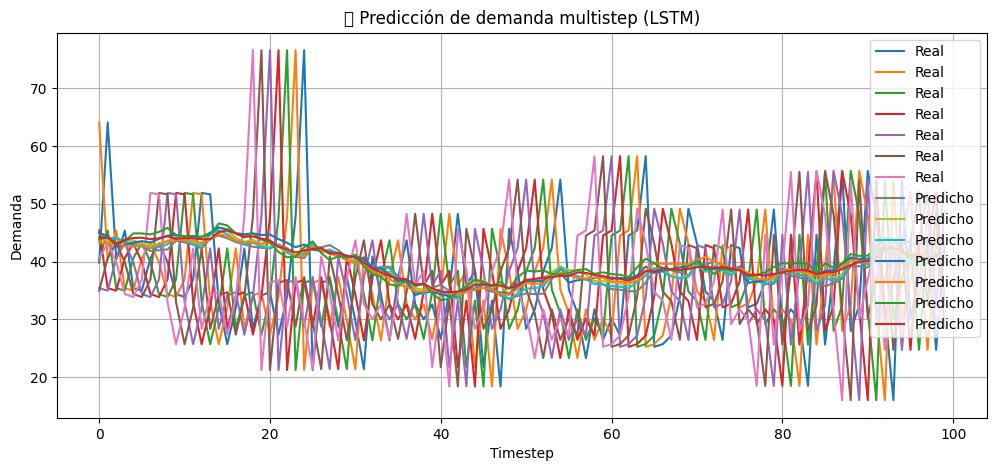

In [5]:
# ✅ Instalar dependencias (si es necesario en Colab)
!pip install -q tensorflow pandas matplotlib scikit-learn

# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ================================
# 1️⃣ Simulación de datos multivariados estilo retail
# ================================
np.random.seed(42)
days = 365 * 2  # 2 años
date_range = pd.date_range(start='2022-01-01', periods=days, freq='D')

df = pd.DataFrame({
    'date': date_range,
    'price': np.random.normal(10, 1, days),
    'promo': np.random.choice([0, 1], size=days, p=[0.7, 0.3]),
    'holiday': np.random.choice([0, 1], size=days, p=[0.9, 0.1])
})

df['base_demand'] = 100 + 10 * df['promo'] - 5 * df['price'] + 15 * df['holiday']
df['seasonality'] = 20 * np.sin(2 * np.pi * df.index / 365)
df['noise'] = np.random.normal(0, 5, days)
df['demand'] = df['base_demand'] + df['seasonality'] + df['noise']

df.set_index('date', inplace=True)
df = df[['price', 'promo', 'holiday', 'demand']]

print("✅ Datos simulados:")
print(df.head())

# ================================
# 2️⃣ Escalado por separado: features y target
# ================================
feature_cols = ['price', 'promo', 'holiday']
target_col = 'demand'

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(df[feature_cols])
scaled_target = target_scaler.fit_transform(df[[target_col]])
scaled = np.concatenate([scaled_features, scaled_target], axis=1)

# ================================
# 3️⃣ Crear secuencias para LSTM (multistep)
# ================================
def create_sequences(data, input_len=30, output_len=7):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len, -1])  # solo demanda
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, input_len=30, output_len=7)
print(f"📦 Secuencias creadas: X = {X.shape}, y = {y.shape}")

# Split en entrenamiento y validación
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# ================================
# 4️⃣ Modelo LSTM para forecasting multistep
# ================================
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])  # salida multistep
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

print("✅ Entrenamiento completado.")

# ================================
# 5️⃣ Evaluación y visualización
# ================================
y_pred = model.predict(X_val)

# Invertir escala solo de demanda
real = target_scaler.inverse_transform(y_val)
pred = target_scaler.inverse_transform(y_pred)

# Métricas
mse = mean_squared_error(real, pred)
mae = mean_absolute_error(real, pred)
print(f"📊 MSE: {mse:.2f}, MAE: {mae:.2f}")

# Visualización de predicción vs real (primeras 100)
plt.figure(figsize=(12, 5))
plt.plot(real[:100], label='Real')
plt.plot(pred[:100], label='Predicho')
plt.title("📈 Predicción de demanda multistep (LSTM)")
plt.xlabel("Timestep")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


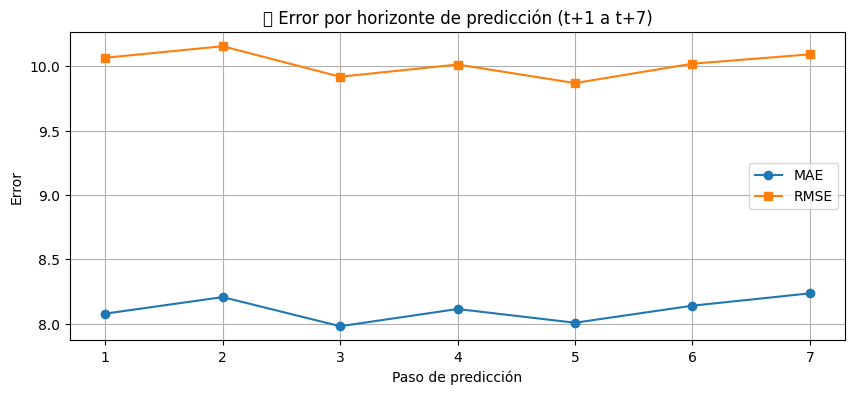

In [6]:
# ================================
# 📊 6️⃣ Evaluación multistep + análisis de errores
# ================================

import seaborn as sns

# Métricas por paso de predicción (t+1 a t+7)
step_mae = []
step_rmse = []

for i in range(y_pred.shape[1]):
    true_step = real[:, i]
    pred_step = pred[:, i]
    step_mae.append(mean_absolute_error(true_step, pred_step))
    step_rmse.append(np.sqrt(mean_squared_error(true_step, pred_step)))

# Visualizar errores por horizonte
plt.figure(figsize=(10, 4))
plt.plot(range(1, 8), step_mae, marker='o', label='MAE')
plt.plot(range(1, 8), step_rmse, marker='s', label='RMSE')
plt.title("📉 Error por horizonte de predicción (t+1 a t+7)")
plt.xlabel("Paso de predicción")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


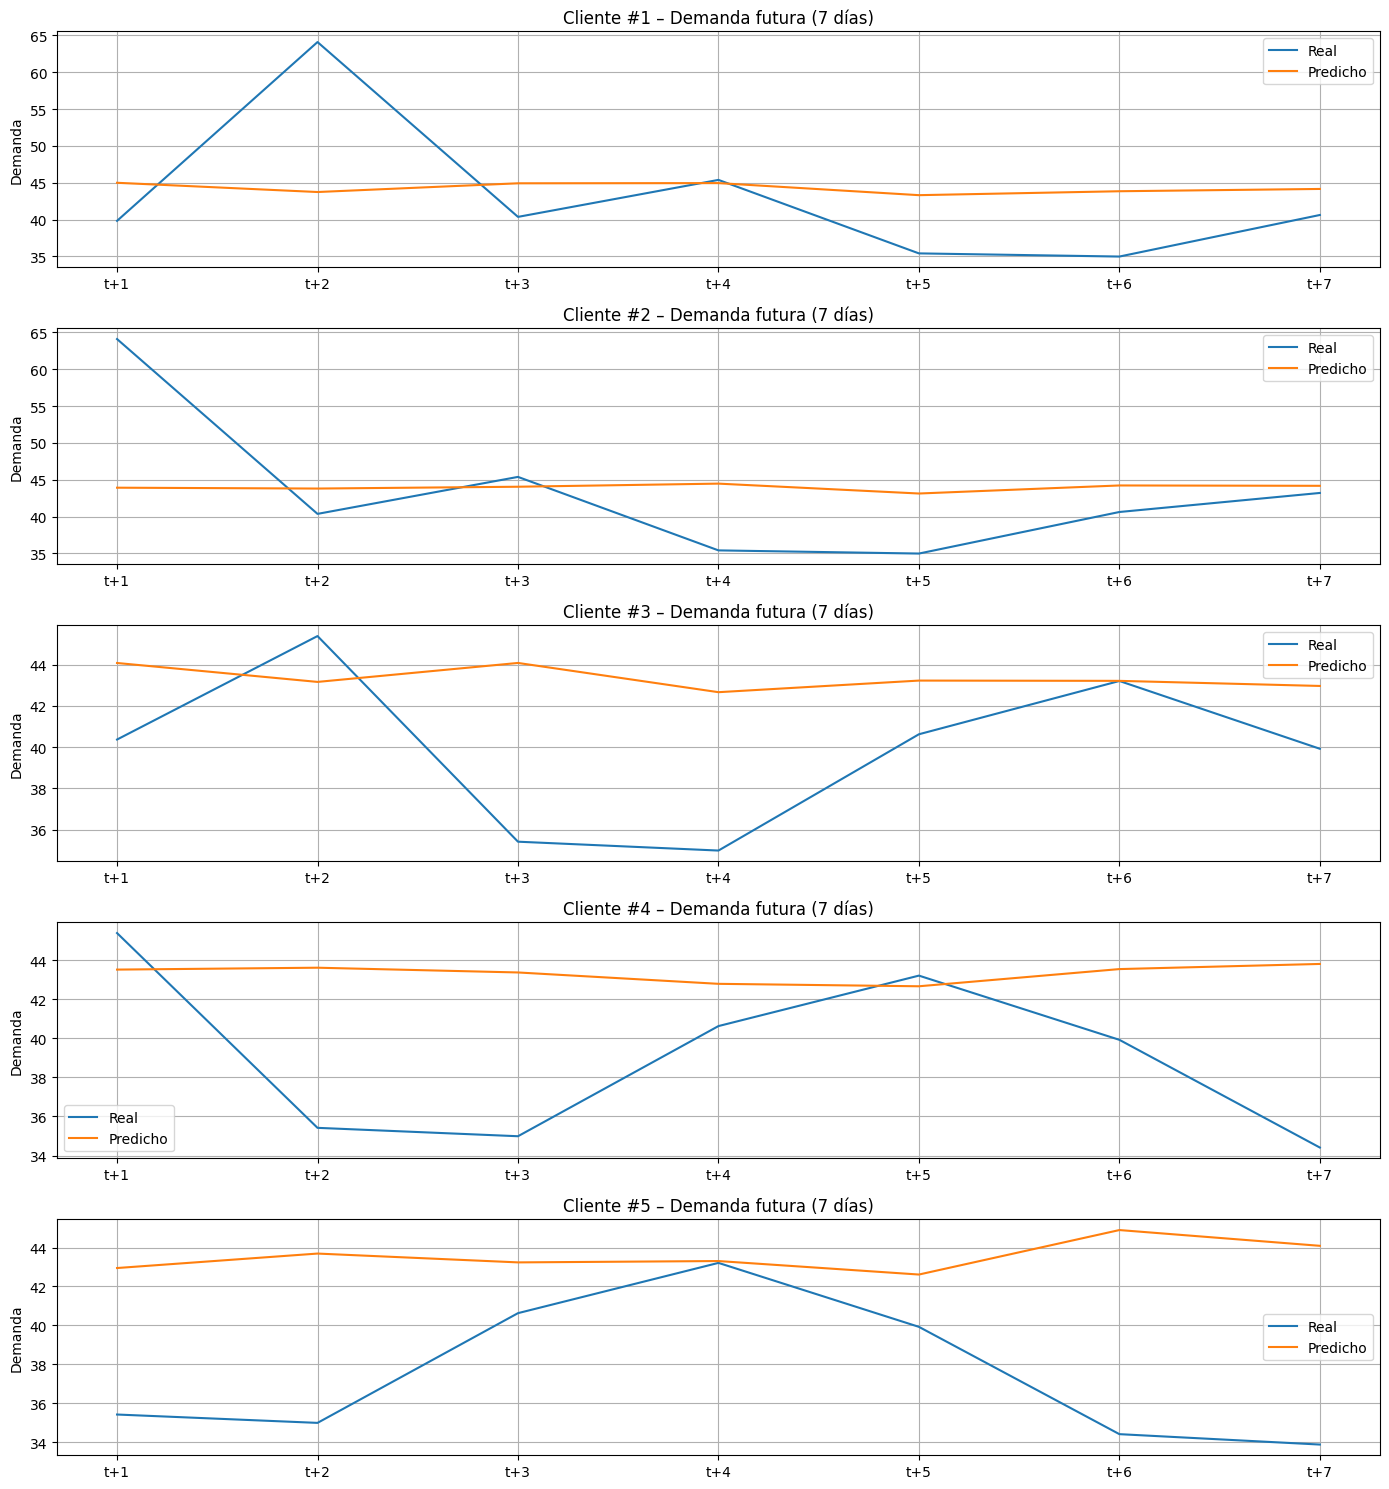

In [7]:
# Visualizar predicción vs real para algunos clientes

samples_to_plot = 5
plt.figure(figsize=(14, samples_to_plot * 3))

for i in range(samples_to_plot):
    plt.subplot(samples_to_plot, 1, i + 1)
    plt.plot(real[i], label='Real')
    plt.plot(pred[i], label='Predicho')
    plt.title(f"Cliente #{i+1} – Demanda futura (7 días)")
    plt.ylabel("Demanda")
    plt.xticks(range(7), [f't+{j+1}' for j in range(7)])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
